In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#leittura dos dados
df_ibovespa = pd.read_csv('dados10anos.csv')
df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.07.2024,124.718,123.905,125.220,123.735,"8,23M","0,65%"
1,28.06.2024,123.907,124.308,124.500,123.298,"9,07M","-0,32%"
2,27.06.2024,124.308,122.642,124.308,122.642,"8,71M","1,36%"
3,26.06.2024,122.641,122.331,122.701,121.402,"8,18M","0,25%"
4,25.06.2024,122.331,122.634,122.849,121.997,"6,94M","-0,25%"


In [3]:

#tratando e ajustando os dados
df = df_ibovespa.copy()[['Último', 'Data', 'Vol.']]
df.rename(columns={'Data': 'data', 'Último': 'ultimo', 'Vol.': 'volume'}, inplace=True)
df['data'] = pd.to_datetime(df.data, format = "%d.%m.%Y")
df.set_index('data', inplace=True)
#Transformando volume em números absolutos
df['volume'] = df['volume'].str.replace('K', '0')
df['volume'] = df['volume'].str.replace('M', '0000')
df['volume'] = df['volume'].str.replace('B', '0000000')
df['volume'] = df['volume'].str.replace(',', '')
df['volume'] = pd.to_numeric(df['volume'])
#Destacando informações da data
df['ano'] = df.index.year
df['mes'] =  df.index.month
df['semana'] =  df.index.day_of_week
#remoção de valores vazios
df.dropna(inplace=True)
df

,ultimo,volume,ano,mes,semana
data,,,,,
2024-07-01,124.718,8230000.0,2024,7,0
2024-06-28,123.907,9070000.0,2024,6,4
2024-06-27,124.308,8710000.0,2024,6,3
2024-06-26,122.641,8180000.0,2024,6,2
2024-06-25,122.331,6940000.0,2024,6,1
...,...,...,...,...,...
2014-01-08,50.577,2920000.0,2014,1,2
2014-01-07,50.430,3340000.0,2014,1,1
2014-01-06,50.974,3730000.0,2014,1,0


<Axes: >

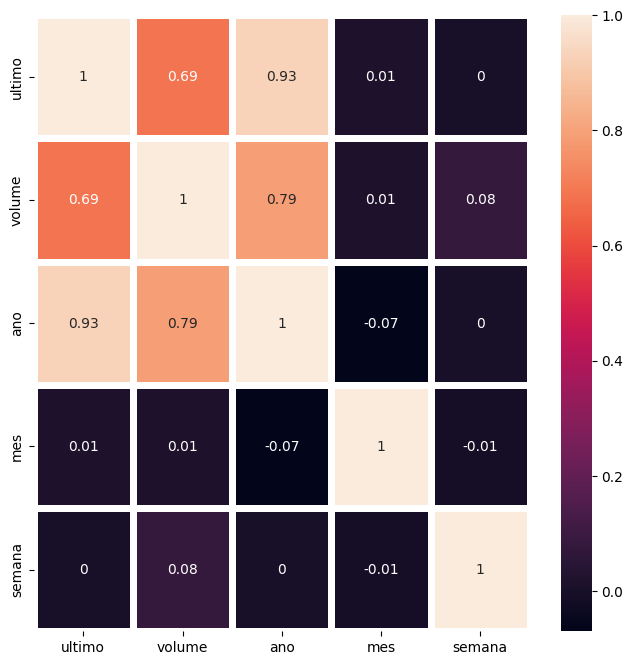

In [4]:
#verificando a correlação entre as variáveis
df_corr = df[['ultimo', 'volume', 'ano', 'mes', 'semana']].copy()
df_corr.dropna(inplace=True)
df_corr['volume'] = df_corr['volume']/1_000_000
matrix_correlacao = df_corr.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=matrix_correlacao, annot=True, linewidths=5, ax=ax)

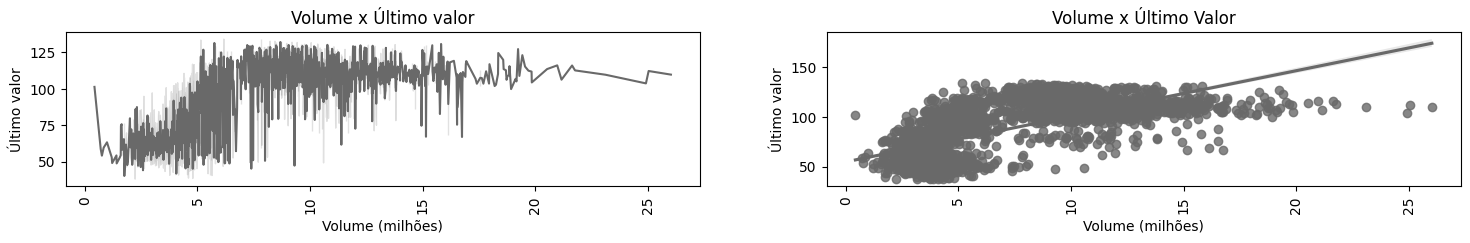

In [5]:
#visualização de correlação entre volume e valor
fig, axes = plt.subplots(1, 2, figsize=(18, 2))

#configuração do gráfico de linha para visualização
sns.lineplot(x='volume', y='ultimo', data=df_corr, ax=axes[0], color="dimgray")
axes[0].set_title('Volume x Último valor')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('Volume (milhões)')
axes[0].set_ylabel('Último valor')

#configuração do gráfico de disperção para visualização
sns.regplot(x='volume', y='ultimo', data=df_corr, ax=axes[1], color="dimgray")
axes[1].set_title('Volume x Último Valor')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('Volume (milhões)')
axes[1].set_ylabel('Último valor')

plt.show()

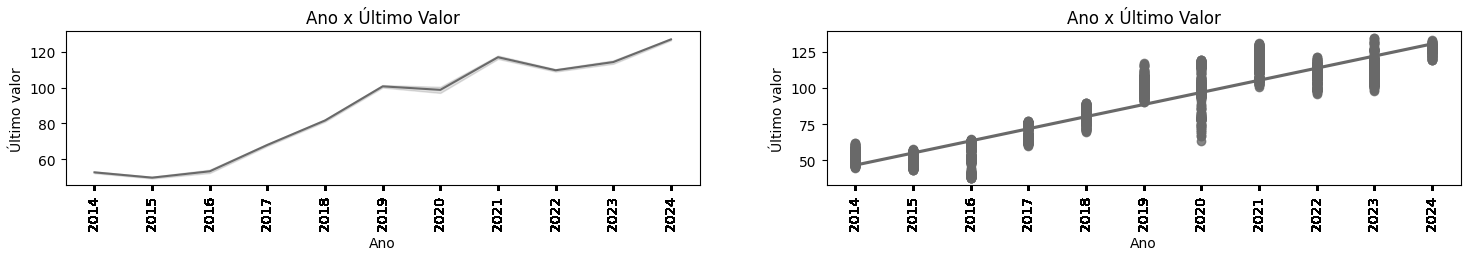

In [6]:
#visualização de correlação entre ano e valor
fig, axes = plt.subplots(1, 2, figsize=(18, 2))

#configuração do gráfico de linha para visualização
sns.lineplot(x='ano', y='ultimo', data=df_corr, ax=axes[0], color="dimgray")
axes[0].set_title('Ano x Último Valor')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticks(df_corr['ano'])
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Último valor')

#configuração do gráfico de disperção para visualização
sns.regplot(x='ano', y='ultimo', data=df_corr, ax=axes[1], color="dimgray")
axes[1].set_title('Ano x Último Valor')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(df_corr['ano'])
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Último valor')

plt.show()

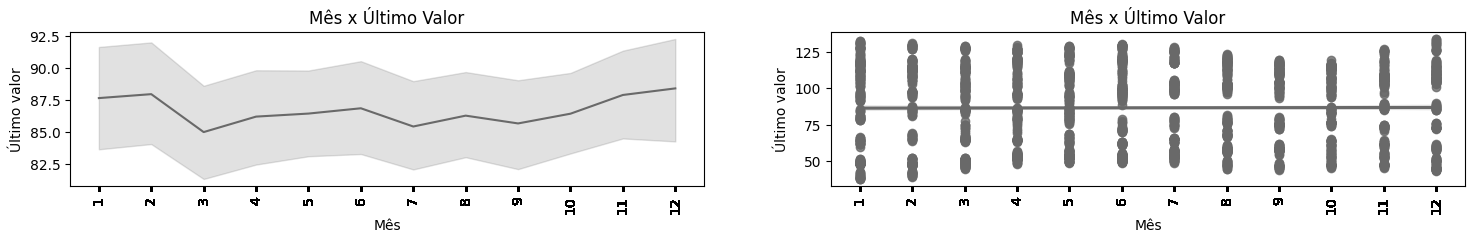

In [7]:
#visualização de correlação entre ano e valor
fig, axes = plt.subplots(1, 2, figsize=(18, 2))

#configuração do gráfico de linha para visualização
sns.lineplot(x='mes', y='ultimo', data=df_corr, ax=axes[0], color="dimgray")
axes[0].set_title('Mês x Último Valor')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xticks(df_corr['mes'])
axes[0].set_xlabel('Mês')
axes[0].set_ylabel('Último valor')

#configuração do gráfico de disperção para visualização
sns.regplot(x='mes', y='ultimo', data=df_corr, ax=axes[1], color="dimgray")
axes[1].set_title('Mês x Último Valor')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xticks(df_corr['mes'])
axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Último valor')

plt.show()

In [8]:
#função para tranformar dias da semana em texto
def transforma_semana(semana):
    if(semana == 0): return 'Segunda'
    elif(semana == 1): return 'Terça'
    elif(semana == 2): return 'Quarta'
    elif(semana == 3): return 'Quinta'
    elif(semana == 4): return 'Sexta'
    else: return semana

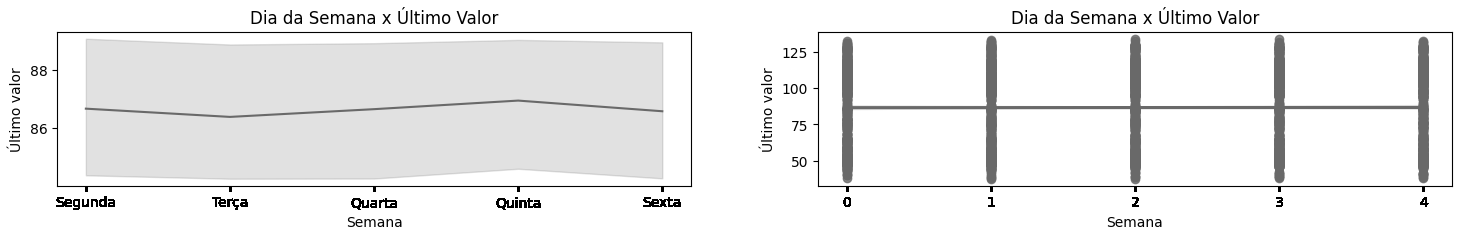

In [9]:
#visualização de correlação entre dia da semana e valor (Vale a pena remover sab e dom)
fig, axes = plt.subplots(1, 2, figsize=(18, 2))

#transformação de numeros representando os dias da semana em texto
df_corr['semana_texto'] = df_corr['semana'].apply(transforma_semana)

# Ordenar a coluna 'semana_texto' como uma categoria com a ordem desejada
dias_da_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
df_corr['semana_texto'] = pd.Categorical(df_corr['semana_texto'], categories=dias_da_semana, ordered=True)

#configuração do gráfico de linha para visualização
sns.lineplot(x='semana_texto', y='ultimo', data=df_corr, ax=axes[0], color="dimgray")
axes[0].set_title('Dia da Semana x Último Valor')
axes[0].set_xticks(df_corr['semana'])
axes[0].set_xlabel('Semana')
axes[0].set_ylabel('Último valor')

#configuração do gráfico de disperção para visualização
sns.regplot(x='semana', y='ultimo', data=df_corr, ax=axes[1], color="dimgray")
axes[1].set_title('Dia da Semana x Último Valor')
axes[1].set_xticks(df_corr['semana'])
axes[1].set_xlabel('Semana')
axes[1].set_ylabel('Último valor')

plt.show()

In [10]:
#Adicionando valores nas datas com lacunas da série temporal
start_date = df.index[len(df.index) -1]
end_date = df.index[0]
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(date_range)

#aplicando a média móvel para remover lacunas na série temporal
media_movel = df['ultimo'].rolling(window=30, min_periods=1).mean()
df['ultimo'] = df['ultimo'].combine_first(media_movel)
media_movel = df['volume'].rolling(window=30, min_periods=1).mean()
df['volume'] = df['volume'].combine_first(media_movel)

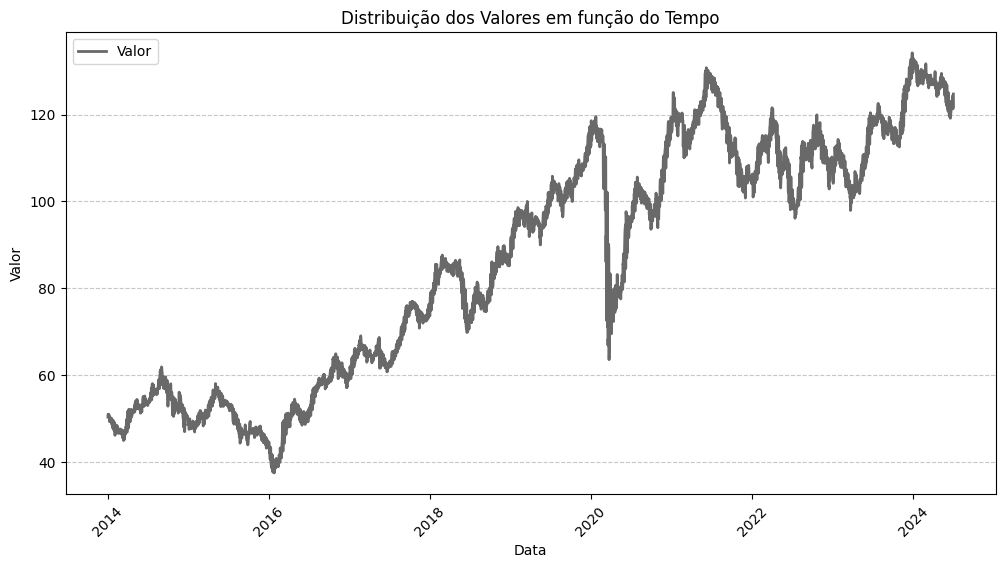

In [11]:
#Plotagem dos dados pós aplicação da média móvel para visualizar os dados
plt.figure(figsize=(12, 6))
sns.lineplot(x='index', y='ultimo', data=df.reset_index(), label='Valor', color='dimgray', linewidth=2)
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Distribuição dos Valores em função do Tempo')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

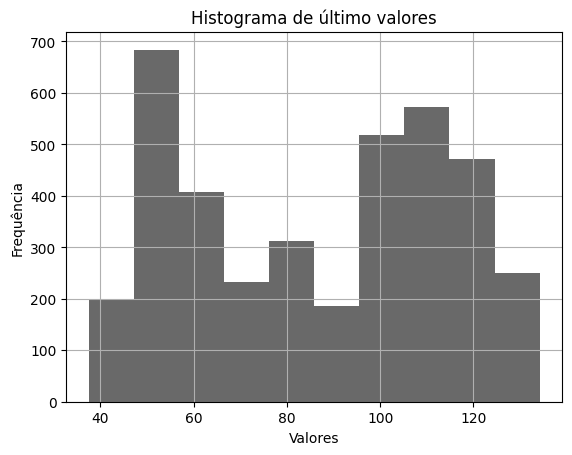

In [12]:
#visualizando a distribuição dos valores
df.ultimo.hist(color='dimgray')
plt.title('Histograma de último valores')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [13]:
#preparando os dados para os modelos de predição
df_predicoes = df['ultimo'].dropna().reset_index().copy()
df_predicoes.columns = ['ds', 'y']
df_predicoes['unique_id'] = 'Ibovespa'
df_predicoes

,ds,y,unique_id
0,2014-01-02,50.341000,Ibovespa
1,2014-01-03,50.981000,Ibovespa
2,2014-01-04,50.661000,Ibovespa
3,2014-01-05,50.661000,Ibovespa
4,2014-01-06,50.974000,Ibovespa
...,...,...,...
3829,2024-06-27,124.308000,Ibovespa
3830,2024-06-28,123.907000,Ibovespa
3831,2024-06-29,121.390762,Ibovespa
3832,2024-06-30,121.355400,Ibovespa


In [14]:
#Cálculos de acerto
calculos_erro = []

#função para retorno estruturado dos erros
def calcula_erro(predicao, real, modelo):
  def symetric_mean_absolute_percentage_error(actual, predicted) -> float:
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), 
        np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2) 
        )*100, 2
    )
  
  mae = mean_absolute_error(real, predicao)
  rmse = mean_squared_error(real, predicao)
  smape = symetric_mean_absolute_percentage_error(real, predicao)
  retorno = {
     'modelo': modelo,
     'mae': mae,
     'rmse': rmse,
     'smape %': smape
  }

  return retorno

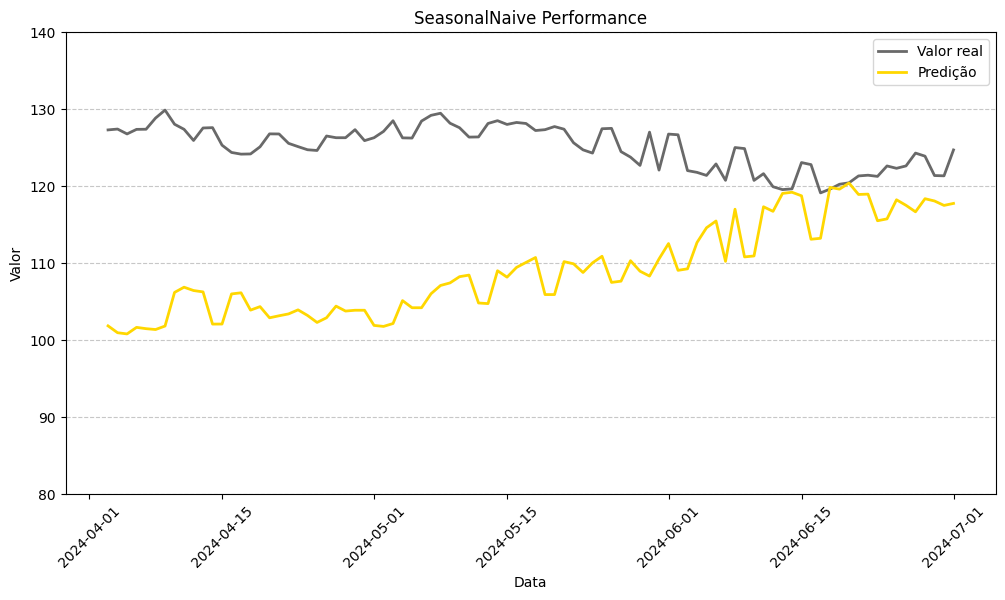

In [15]:
#Modelo SeasonalNaive

#separando as bases de treino e teste
index_seasonal = df_predicoes['unique_id'].count() - 90
treino_seasonal = df_predicoes.loc[:index_seasonal-1]
valid_seasonal = df_predicoes.loc[index_seasonal:]
h = valid_seasonal['ds'].nunique()

model = StatsForecast(models=[SeasonalNaive(season_length=365)], freq='D', n_jobs=-1) #instancia
model.fit(treino_seasonal) #treinamento

#Predições de teste
forecast_df = model.predict(h=h, level=[90])
forecast_df = forecast_df.reset_index().merge(valid_seasonal, on=['ds', 'unique_id'], how='left')
forecast_df.dropna(inplace=True)

#calculo de erro com base na função criada
calculos_erro.append(calcula_erro(forecast_df['y'].values, forecast_df['SeasonalNaive'].values, 'SeasonalNaive'))

#preparação dos dados para plotagem
dados_seasonal_naive = valid_seasonal.merge(forecast_df)

#Configuração da plotagem dos dados
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=dados_seasonal_naive, label='Valor real', color='dimgray', linewidth=2)
sns.lineplot(x='ds', y='SeasonalNaive', data=dados_seasonal_naive, label='Predição', color='gold', linewidth=2)
plt.ylim(80,140)
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('SeasonalNaive Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Observação
- Neste ponto é dividido os dados da base inteira para a utilização do modelo ARIMA.
- Utilizamos 1 ano de treinamento para respeitar a sazonalidade observada em gráficos anteriores, e adicionamos um período de 90 dias para utilizar como validação.
- Além disso, é realizado o teste de Adfuller para validar se os dados estão estacionários.

Teste ADF
Teste Estatístico: -2.014921813560541
P-Value: 0.28006897221395644
Valores críticos:
	1%: -3.4451978474132234
	5%: -2.8680864144212057
	10%: -2.5702569996789792


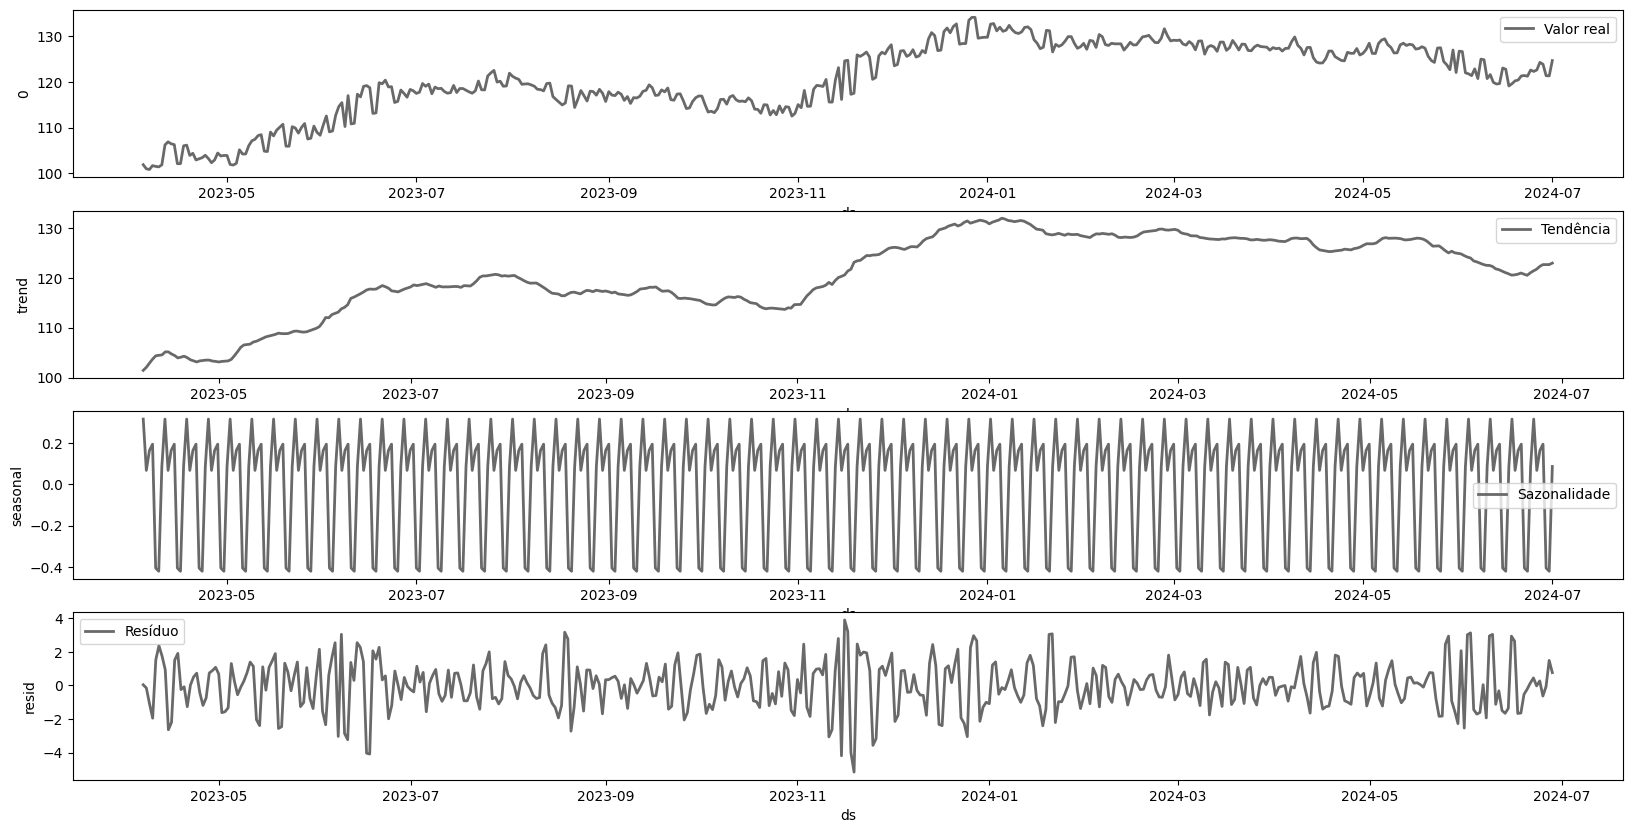

In [16]:
#Validação dos dados estacionários para o ARIMA - filtro de periodo de tem de 1 ano (treino) + 90 dias (teste)
df_arima = df_predicoes.tail(455)[['ds', 'y']].set_index('ds')
decompose_arima = seasonal_decompose(df_arima)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (20,10))

#Plotagem da decomposição dos dados
sns.lineplot(x='ds', y=0, data=decompose_arima.observed.reset_index(), label='Valor real', color='dimgray', linewidth=2, ax=ax1)
sns.lineplot(x='ds', y='trend', data=decompose_arima.trend.reset_index(), label='Tendência', color='dimgray', linewidth=2, ax=ax2)
sns.lineplot(x='ds', y='seasonal', data=decompose_arima.seasonal.reset_index(), label='Sazonalidade', color='dimgray', linewidth=2, ax=ax3)
sns.lineplot(x='ds', y='resid', data=decompose_arima.resid.reset_index(), label='Resíduo', color='dimgray', linewidth=2, ax=ax4)

#Validação do Adfuller
result = adfuller(df_arima.values)
print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")
for key, value in result[4].items():
  print(f"\t{key}: {value}")

# Observação
- Como os dados não estão estacionário (a hípotese nula é correta), foi necessário realizar uma diferenciação entre a média móvel e os dados, ambos em escala logaritímica. Dessa forma atingimos a hípotese alternativa.

Teste ADF
Teste Estatístico: -4.457551820604318
P-Value: 0.00023444426769181107
Valores críticos:
	1%: -3.4454725477848998
	5%: -2.8682072297316794
	10%: -2.570321396485665


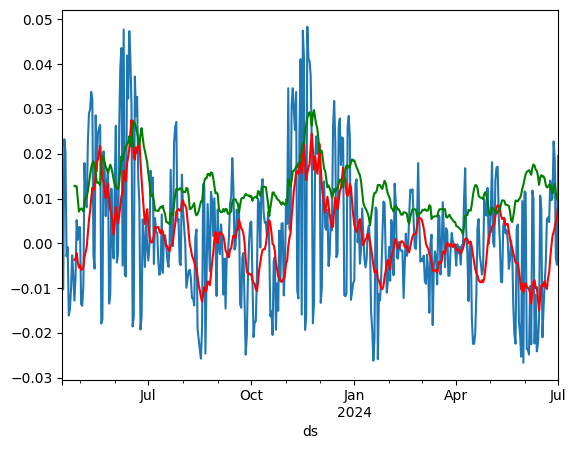

In [17]:
#Transformações dos dados com o proposito de estacionar os dados
df_arima_log = np.log(df_arima) #escala logarítmica
ma_arima_log = df_arima_log.rolling(12).mean() #média móvel
df_arima_s = (df_arima_log - ma_arima_log).dropna() #diferenciação

#Preparação para visualização dos dados
ma_arima_s = df_arima_s.rolling(12).mean()
std = df_arima_s.rolling(12).std()
f, ax = plt.subplots()
df_arima_s.plot(ax=ax, legend=False)
ma_arima_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
result = adfuller(df_arima_s.values)

#Validação do Adfuller
print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")
for key, value in result[4].items():
  print(f"\t{key}: {value}")

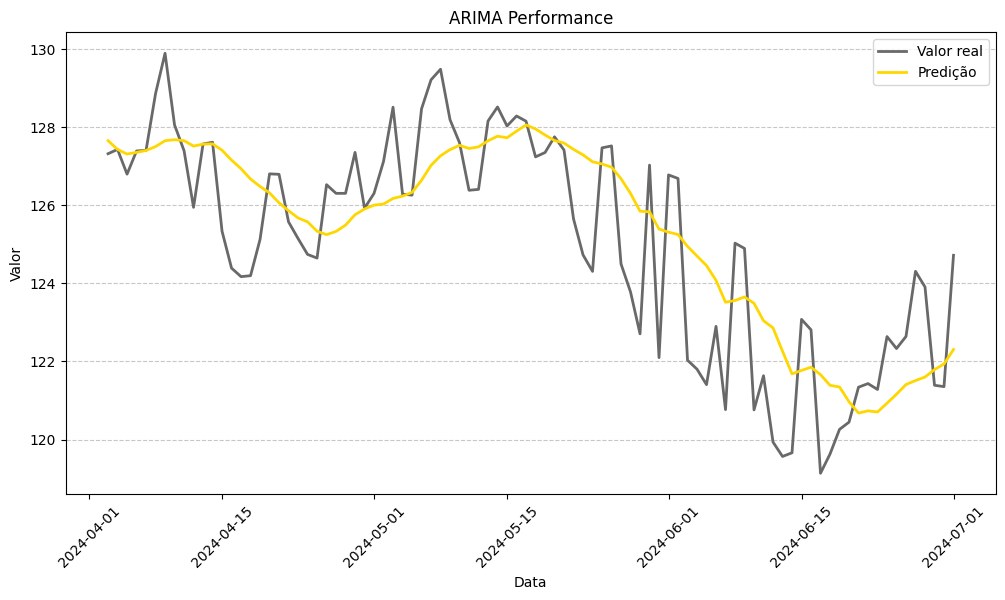

In [18]:
#ARIMA

#separando as bases de treino e teste
df_arima_s = df_arima_s.reset_index()
df_arima_s['unique_id'] = 'Ibovespa'
index_arima = df_arima_s['unique_id'].count() - 90
treino_arima = df_arima_s.loc[:index_arima-1]
valid_arima = df_arima_s.loc[index_arima:]
h_arima = valid_arima['ds'].nunique()

model_a = StatsForecast(models=[AutoARIMA(season_length=60)], freq='D', n_jobs=-1) #instância
model_a.fit(treino_arima) #treinamento

#Predições de teste
forecast_dfa = model_a.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid_arima, on=['ds', 'unique_id'], how='left')
forecast_dfa.dropna(inplace=True)


#preparação dos dados para plotagem
dados_arima = valid_arima.merge(forecast_dfa)
dados_arima['data'] = dados_arima['ds']
dados_arima = dados_arima.set_index('ds')
dados_arima['y'] = np.exp(dados_arima['y'] + ma_arima_log['y'])
dados_arima['AutoARIMA'] = np.exp(dados_arima['AutoARIMA'] + ma_arima_log['y'])

#calculo de erro com base na função criada
calculos_erro.append(calcula_erro(dados_arima['y'].values, dados_arima['AutoARIMA'].values, 'AutoARIMA'))

#Configuração da plotagem dos dados
plt.figure(figsize=(12, 6))
sns.lineplot(x='data', y='y', data=dados_arima, label='Valor real', color='dimgray', linewidth=2)
sns.lineplot(x='data', y='AutoARIMA', data=dados_arima, label='Predição', color='gold', linewidth=2)
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('ARIMA Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Observação
- Como observamos uma correlação de mudança significativa ao passar dos anos, na sequência de treinamento utilizada na RNN, separamos em 365 dias por predição.
    - Como destaque temos uma melhora no erro em todos os cálculos utilizados. Já como ponto de atenção, as predições trazem a necessidade de conhecimento minímo de 1 ano no passado.

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.1467
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0184
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0173
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0175
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0181
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.0178
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0179
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 0.0174
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0166
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 0.0176
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0173
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 0.0177
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0175
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0161
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - lo

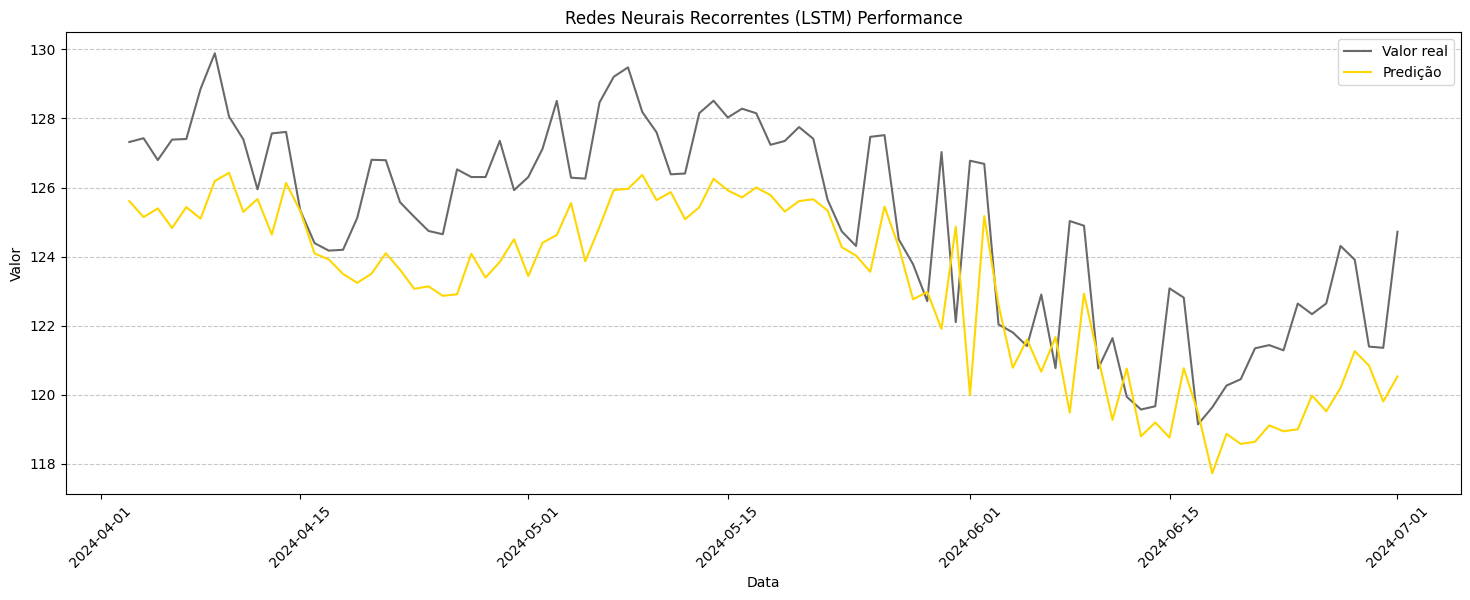

In [19]:
#Redes Neurais Recorrentes (LMST)
df_tensorflow = df_predicoes.copy()
df_tensorflow['ds'] = pd.to_datetime(df_tensorflow['ds'])

# Ordenar por data
df_tensorflow = df_tensorflow.sort_values('ds')

# Resetar o índice
df_tensorflow.reset_index(drop=True, inplace=True)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_tensorflow[['y']])

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Definir o tamanho da sequência
seq_length = 365

# Criar sequências de treino
X, y = create_sequences(scaled_data, seq_length)

# Dividir em conjuntos de treino e teste
split = -90
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Fazer predições
predicted_prices = model.predict(X_test)

# Desnormalizar os dados
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test)

#calculo de erro com base na função criada
calculos_erro.append(calcula_erro(y_test, predicted_prices, 'LSTM'))

#Configuração de plotagem dos dados
plt.figure(figsize=(18, 6))
plt.plot(df_tensorflow['ds'][-len(y_test):], y_test, color='dimgray', label='Valor real')
plt.plot(df_tensorflow['ds'][-len(y_test):], predicted_prices, color='gold', label='Predição')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Redes Neurais Recorrentes (LSTM) Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
#Conversão da tabela de erros para um dataframe e apresentação
df_erros = pd.DataFrame(calculos_erro)
df_erros

,modelo,mae,rmse,smape %
0,SeasonalNaive,15.974489,320.255077,13.74
1,AutoARIMA,1.291677,2.597208,1.04
2,LSTM,2.081151,6.041962,1.67
